In [16]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow yfinance


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf  # To fetch stock data
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [18]:
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2015-01-01", end="2024-01-01")  # 9 years of data
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400
2015-01-05,23.635286,24.169166,23.448429,24.089084,257142000
2015-01-06,23.637508,23.897774,23.274914,23.699794,263188400
2015-01-07,23.968956,24.069058,23.735383,23.846608,160423600
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000


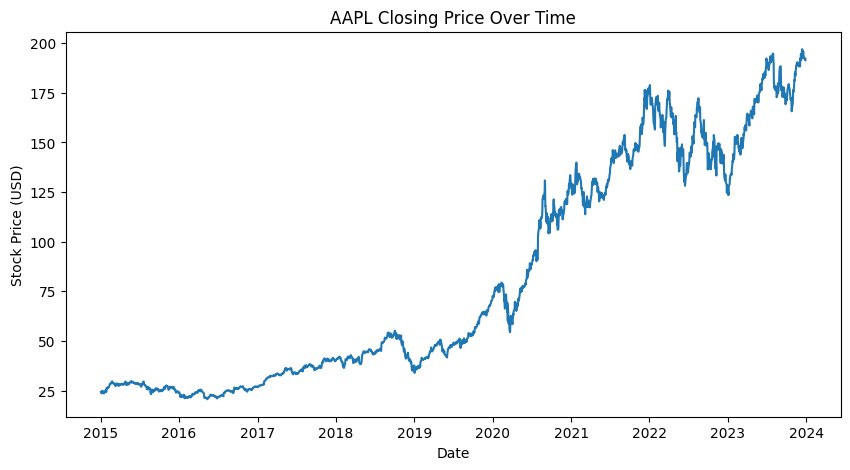

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(data['Close'])
plt.title(f"{stock_symbol} Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.show()


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])


In [21]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

# Reshape X for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [22]:
split = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [23]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0439 - val_loss: 0.0024
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 9.3631e-04 - val_loss: 0.0033
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8.3393e-04 - val_loss: 0.0040
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step -

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


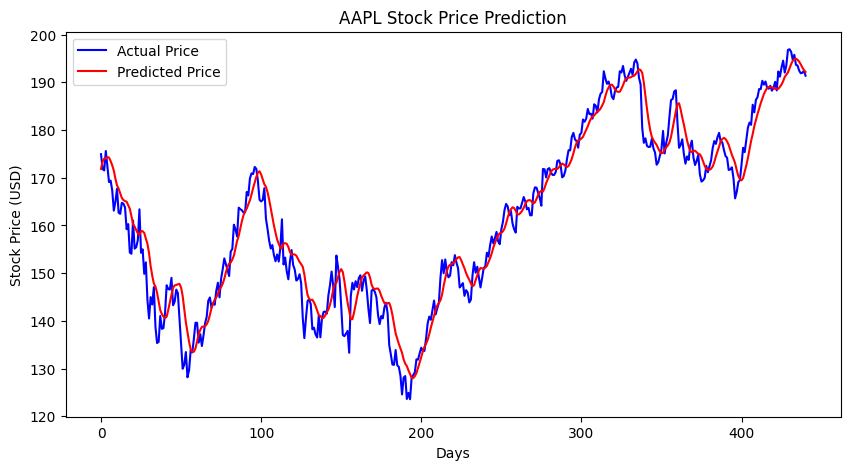

In [24]:
y_pred = model.predict(X_test)

# Inverse Transform Predictions
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, color="blue", label="Actual Price")
plt.plot(y_pred_inv, color="red", label="Predicted Price")
plt.legend()
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Stock Price (USD)")
plt.show()


In [25]:
last_60_days = scaled_data[-60:]  # Take last 60 days
future_input = np.reshape(last_60_days, (1, 60, 1))
predicted_price = model.predict(future_input)

# Convert prediction back to original price
predicted_price = scaler.inverse_transform(predicted_price)
print(f"Predicted Next Day Price: ${predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Next Day Price: $191.78
